In [1]:
# Here we will train a machine learning model using our preprocessed population statistics and road network data
# Typical data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [45]:
# First, let's load our preprocessed data

dataSetName = 'ON'
census2016 = pd.read_csv(f'./processedData/processed_{dataSetName}_2016.csv')
census2021 = pd.read_csv(f'./processedData/processed_{dataSetName}_2021.csv')
# roadNetwork = pd.read_csv('./processedData/processed_NL_roadNetwork.csv')

In [51]:
# Note that the counts are different on our datasets. Let's take a subset of the 2021 data that matches 
# the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
trimmed2021 = census2021[census2021['GEO_NAME'].isin(census2016['GEO_NAME'])]
# We only need the GEO_NAME for cross referencing, and the population count for training
trimmed2021 = trimmed2021[['GEO_NAME', 'Population, 2021']]
# Drop any rows with missing population data
trimmed2021 = trimmed2021.dropna()

# Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
trimmed2016 = census2016[census2016['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]

# As a last step before we are done, we need to sort the dataframes by the community name so that the
# data is in the same order for both datasets
trimmed2016 = trimmed2016.sort_values(by='GEO_NAME')
trimmed2021 = trimmed2021.sort_values(by='GEO_NAME')

print(f'Trimmed 2016 data Shape: {trimmed2016.shape}')
print(f'Trimmed 2021 data Shape: {trimmed2021.shape}')


Trimmed 2016 data Shape: (523, 214)
Trimmed 2021 data Shape: (523, 2)


In [52]:
# Now we can train our model. We will use the 2016 data as our X values and the 2021 data as our y values.
from sklearn.model_selection import train_test_split

X = trimmed2016.drop(columns=['GEO_NAME'])
y = trimmed2021['Population, 2021']

# Split the training data into training and validation sets
XTrain, XVal, yTrain, yVal = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=42)

In [53]:

# We will use a pipeline to preprocess our data
# All features here are numeric, so we will use a simple imputer to fill in missing values
# and a standard scaler to scale the data
numericTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Using most frequent to avoid outliers skewing the data
    ('scaler', StandardScaler())
])

# Setting up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericTransformer, X.columns)
    ]
)

# Now we can set up our model
# We'll use a random forest regressor
numberOfTrees = 100
regressor = RandomForestRegressor(n_estimators=numberOfTrees, random_state=42)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Train the model
model.fit(XTrain, yTrain)
None

In [54]:
# Predict our values
yPred = model.predict(XVal)

# Calculate the root mean squared error
valRmse = np.sqrt(mean_squared_error(yVal, yPred, squared=False))
# Calculate the R^2 value
valR2 = r2_score(yVal, yPred)

print(f'Validation RMSE: {valRmse}')
print(f'Validation R^2: {valR2}')

print(f'Mean of validation set: {round(yTrain.mean())}')
print(f'Validation RMSE as a percentage of the mean: {round(valRmse / yTrain.mean() * 100, 2)}%')


Validation RMSE: 87.12359458259196
Validation R^2: 0.9869669762566148
Mean of validation set: 28379
Validation RMSE as a percentage of the mean: 0.31%


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


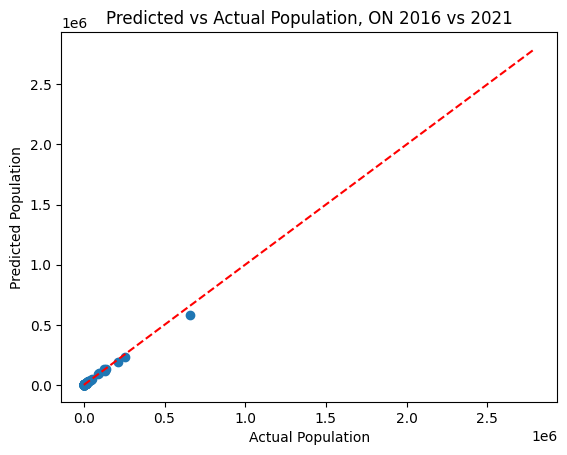

In [55]:
# Let's plot the predicted vs actual values
plt.scatter(yVal, yPred)
# Add a line for perfect correlation
plt.plot([y.min(), y.max()], [y.min(), y.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title(f'Predicted vs Actual Population, {dataSetName} 2016 vs 2021')

# As with the other plots, let's save things to our figures folder
plt.savefig(f'./figures/predicting_vs_actual_census_only_{dataSetName}.png')


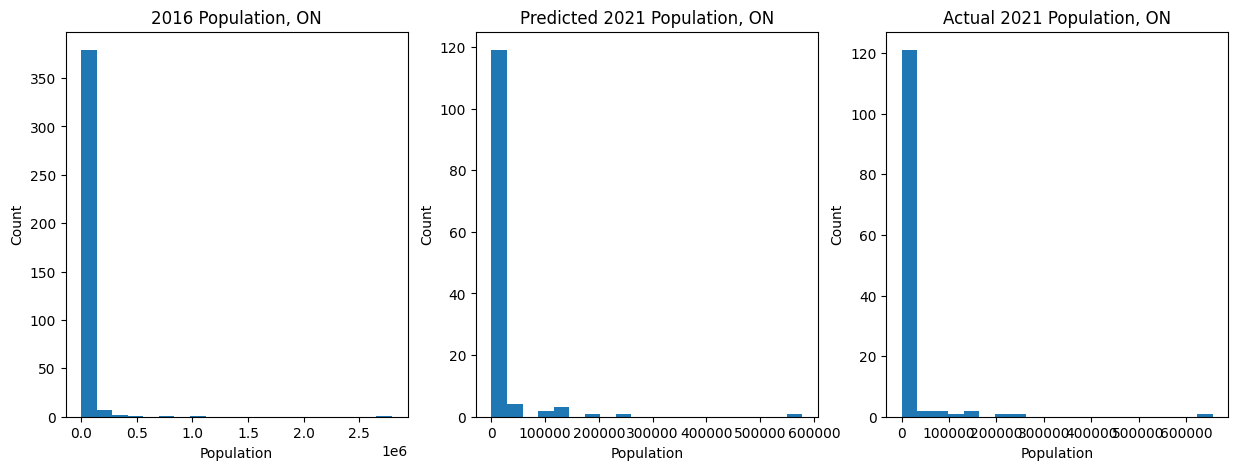

In [56]:
# Let's also plot the 2016 distribution, the predicted distribution, and the actual distribution
# as a set of subplots.
# This will let us see how the communities changed over time
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
dataSets = [yTrain, yPred, yVal]
titles = [f'2016 Population, {dataSetName}', f'Predicted 2021 Population, {dataSetName}', f'Actual 2021 Population, {dataSetName}']
for i in range(3):
    axs[i].hist(dataSets[i], bins=20)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population')
    axs[i].set_ylabel('Count')

# Let's save the plot in our figures folder
plt.savefig(f'./figures/pred_distributions_census_only_{dataSetName}.png')



In [32]:
# Let's train our model using the road network data and the 2021 population targets
# First we will need to import the roadCharacteristics file

networks = pd.read_csv('./processedData/networkCharacteristics.csv')
networks.head()

,Unnamed: 0,Node Connectivity,Betweenness Centrality,Average Node Degree,Top 10% BC
0,Aberdeen,1,"{1638571580: 0.0, 1638571707: 0.02531645569620...",4.550000,0.505883
1,Acadieville,1,"{1665424050: 0.0, 1665425717: 0.0, 1665427309:...",4.203390,0.506352
2,Addington,0,"{604124914: 0.1076792705080486, 1020806170: 0....",5.054902,0.162141
3,Alma,1,"{16878195: 0.4796404019037546, 857586389: 0.20...",4.063492,0.469240
4,Alnwick,1,"{1729459293: 0.0, 1729460255: 0.01059597042722...",4.518519,0.281422


In [33]:
# First we will need to rename the first column, and match the community names to the appropriate 2021 data
# networks = networks.rename(columns={'Unnamed: 0': 'GEO_NAME'})
# trimmedNetworks = networks[networks['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]
# trimmedNetworks.shape

# # Next we will trim the 2021 data to match the trimmed networks community names
# populationForNetworks2021 = trimmed2021[trimmed2021['GEO_NAME'].isin(trimmedNetworks['GEO_NAME'])]

# # And then we need to reorder, as we did when working with the census data
# populationForNetworks2021 = populationForNetworks2021.sort_values(by='GEO_NAME')
# trimmedNetworks = trimmedNetworks.sort_values(by='GEO_NAME')

# print(populationForNetworks2021.shape)
# print(trimmedNetworks.shape)



(169, 2)
(169, 5)


In [24]:
# # Now we can train our model. We will use the road network data as our X values and the 2021 data as our y values.
# # From the road networks, we will use Node Connectivity, average node degree, and top 10% BC
# XNetworks = trimmedNetworks.drop(columns=['GEO_NAME', 'Betweenness Centrality'])
# yNetworks = populationForNetworks2021['Population, 2021']

# # Split the training data into training and validation sets
# XTrainNetworks, XValNetworks, yTrainNetworks, yValNetworks = train_test_split(XNetworks, yNetworks, test_size=0.2, random_state=314159)

# # We can use a similar pipeline to before, but we will need to define a new preprocessor for the network data
# numericTransformerNetworks = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('scaler', StandardScaler())
# ])

# preprocessorNetworks = ColumnTransformer(
#     transformers=[
#         ('num', numericTransformerNetworks, XNetworks.columns)
#     ]
# )

# # Now we can set up our model
# # We'll use a random forest regressor as before
# networkTrees = 100
# networkRegressor = RandomForestRegressor(n_estimators=networkTrees, random_state=314159)
# networkModel = Pipeline(steps=[
#     ('preprocessor', preprocessorNetworks),
#     ('regressor', networkRegressor)
# ])


In [25]:
# # Now we can train our model
# networkModel.fit(XTrainNetworks, yTrainNetworks)
# None

In [26]:
# # Predict our values
# yPredNetworks = networkModel.predict(XValNetworks)

# # Calculate the root mean squared error
# valRmseNetworks = np.sqrt(mean_squared_error(yValNetworks, yPredNetworks, squared=False))
# # Calculate the R^2 value
# valR2Networks = r2_score(yValNetworks, yPredNetworks)

# print(f'Validation RMSE: {valRmseNetworks}')
# print(f'Validation R^2: {valR2Networks}')

Validation RMSE: 73.7730245110908
Validation R^2: 0.742467139591463


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean of validation set: 2829
Validation RMSE as a percentage of the mean: 2.61%


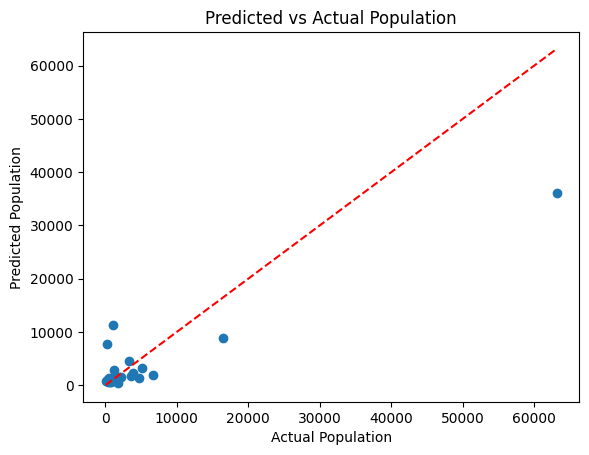

In [27]:
# # Again, let's compare with the mean of the training data
# print(f'Mean of validation set: {round(yTrainNetworks.mean())}')
# print(f'Validation RMSE as a percentage of the mean: {round(valRmseNetworks / yTrainNetworks.mean() * 100, 2)}%')

# # Let's plot the predicted vs actual values
# plt.scatter(yValNetworks, yPredNetworks)
# # Add a line for perfect correlation
# plt.plot([yValNetworks.min(), yValNetworks.max()], [yValNetworks.min(), yValNetworks.max()],  '--', color='red')
# plt.xlabel('Actual Population')
# plt.ylabel('Predicted Population')
# plt.title('Predicted vs Actual Population')
# plt.savefig('./figures/predicting_vs_actual_networks_only.png')

In [ ]:
# Predict with RN + Census
# Predict for a different province

# Train on Canada and repeat